Code for screening docking strand to match imager B (AAGAAGTAAAGGGAG) while avoiding other imagers.

In [1]:
%pylab inline
import itertools
import pandas as pd

import Bio
from Bio import Seq, SeqUtils, Align
from Bio.SeqUtils import MeltingTemp
mpl.rcParams['figure.facecolor'] = 'white'

Populating the interactive namespace from numpy and matplotlib


In [2]:
color_lookup = {"A":"#5050FF", "C": "#E00000", "G":"#00C000", "T":"#E6E600", "U":"#CC9900"}

In [3]:
# set up Aligner object

aligner = Align.PairwiseAligner()
aligner.mode = "local"
aligner.open_gap_score = -0.5
aligner.extend_gap_score = -0.1
aligner.mismatch = -0.0

# print (aligner)

In [4]:
# functions for checking alignement and melting temperature between 2 sequences

def compare_dict_seq(seq1_dict, seq1_key, seq2_dict, seq2_key, aligner=aligner):
    seq1 = seq1_dict[seq1_key]
    seq2 = seq2_dict[seq2_key]
    compare(seq1, seq2, aligner, seq1_key, seq2_key)
    
def compare(seq1, seq2, aligner=aligner, seq1_key=None, seq2_key=None):
    alignments = aligner.align(seq1, seq2.reverse_complement())
    if len(alignments) > 1:
        print("More than 1 successful alignment")
    shift = max(alignments[0].path[0]) * (-1 if alignments[0].path[0][0] > 0 else 1)
#     print shift
    melt = MeltingTemp.Tm_NN(seq1, strict=False, c_seq=seq2[::-1], shift=shift)
    print("{} vs {}, {} matches, {:.2f} C melt. temp.".format(seq1 if seq1_key is None else seq1_key,
                                                              seq2 if seq2_key is None else seq2_key,
                                                              alignments[0].score, melt))
    print(alignments[0])

In [5]:
# function plotting a summary of the filtered sequences

def breakdown(raw_data, masks=None):
    if not masks is None:
        masks_array = np.asarray(masks)
        mask_cum = np.cumprod(masks_array, axis=0)
        mask_all = np.prod(masks_array, axis=0, dtype=bool)
        data = raw_data[mask_all]
    else:
        data = raw_data
    
    print("seqs remaining: {}".format(len(data)))
    
    sequences = data['seq']

    # Displays the relative frequency of bases at each position (after masking if supplied)
    summary = dict()
    for i in range(sequences.shape[1]):
        bases = sequences[:, i]
        unique, counts = numpy.unique(bases, return_counts=True)
        for uni, ct in zip(unique, 1.0*counts/counts.sum()):
            if not uni in summary:
                summary[uni] = np.zeros(sequences.shape[1])
            summary[uni][i] = ct

    fig, ax = subplots(1,1, figsize=(5,4))
    bottom = np.zeros(sequences.shape[1])
    for key in sorted(summary.keys()):
        val = summary[key]
        ax.bar(range(val.shape[0]), val, bottom=bottom, color=color_lookup[key], label=key)
        bottom += val
    ax.legend(bbox_to_anchor=(0.5, 1.2), loc=9, ncol=len(summary))
    ax.set_xlabel("nucleotide #")
    ax.set_ylabel("proportion")
    
    # Plots the parameters provided
    # Each parameter is plotted in a historgram if no mask is provide, otherwise 2 historgrams are displayed for pre/post mask
    keys_to_plot = list(data.dtype.names)
    keys_to_plot.remove('seq')
    for key in keys_to_plot:
        
        if masks is None:
            fig, axes = subplots(1, 1, figsize=(5,4))
            axes = [axes]
        else:
            fig, axes = subplots(1, 2, figsize=(10,4))            
            data_to_plot = raw_data[key]
            if np.issubdtype(data_to_plot.dtype, np.int32):
                range_x = np.arange(data_to_plot.min()-0.5, data_to_plot.max()+1.5, 1)
            else:
                range_x = np.linspace(np.percentile(data_to_plot, 1)-0.5, np.percentile(data_to_plot, 99)+0.5, 20)
                
            axes[0].hist(data_to_plot, range_x, label='all')
#             print(mask_cum.shape)
            for i in np.arange(mask_cum.shape[0]):
                axes[0].hist(data_to_plot[mask_cum[i].astype(bool)], range_x, label='mask {}'.format(i), alpha=1)
        
        data_to_plot = data[key]
#         print(data_to_plot.min(), data_to_plot.max())
        if np.issubdtype(data_to_plot.dtype, np.int32):
            range_x = np.arange(data_to_plot.min()-0.5, data_to_plot.max()+1.5, 1)
        else:
            range_x = np.linspace(np.percentile(data_to_plot, 1)-0.5, np.percentile(data_to_plot, 99)+0.5, 20)
        axes[-1].hist(data_to_plot, range_x, label='final')        
        
        for ax in axes:
            ax.set_xlabel(key)
            ax.set_ylabel("frequency")
            ax.legend(loc=0)
            

In [6]:
# functions to help with filtering by position

def match_start(lookup_array, ref, num, exact=True):
    return match(lookup_array, ref, 0, num, exact)

def match_end(lookup_array, ref, num, exact=True):
    return match(lookup_array, ref, len(ref)-num, len(ref), exact)

def match(lookup_array, ref, start, end, exact=True):
    """
    if exact, match subsequence at specified positions, bases bordering sequence should specifically not match
    """
    mask = np.ones(lookup_array.shape[0], dtype=bool)
    for i in range(start, end):
        mask &= lookup_array[:, i] == ref[i]
    if exact:
        if start > 0:
            i = start - 1
            mask &= (lookup_array[:, i] != ref[i])
        if end < len(ref):
            i = end
            mask &= (lookup_array[:, i] != ref[i])
    return mask


In [7]:
imager_dict = dict()
imager_dict["Imager A"] = Seq.Seq("AGAAGTAATGTGGAA", )
imager_dict["Imager B"] = Seq.Seq("AAGAAGTAAAGGGAG", )
imager_dict["Imager C"] = Seq.Seq("TAAATAAAGCAAAGT", )

In [8]:
def generate_seq_data(imager_dict, imager_names, start_fixed=2, end_fixed=2):
    """
    Generate all possible sequences with the same length as the first imager provided.
    Takes 10+ minutes. Fixing the end bases will significantly improve the speed.
    
    Calculates various parameters with the aim of designing a docking strand for the first imager.
    """
    
    imager_1, imager_2, imager_3 = [imager_dict[name] for name in imager_names]
    
    full_len = len(imager_1)
    
    cache_name = "cache({})({})({})_{}-{}.npz".format(imager_names[0], imager_names[1], imager_names[2], start_fixed, end_fixed)

    try:        
        docking_results = np.load(cache_name)["arr_0"]
    except:
        print("failed to load from cache.")

        imager_1_rc = imager_1.reverse_complement()

        dtype = [
            ('seq', 'U{}'.format(full_len)),
    #         ('seq', '{}U1'.format(len(base_imager))),
            ('melt temp match', np.float),
            ('align count match', np.int),
            ('align score match', np.float),
            ('align path count match', np.int),
            ('melt temp self', np.float),
            ('align count self', np.float),
            ('align score self', np.float),
            ('melt temp mismatch 1', np.float),
            ('align count mismatch 1', np.int),
            ('align score mismatch 1', np.float),
            ('align path count mismatch 1', np.int),
            ('melt temp mismatch 2', np.float),
            ('align count mismatch 2', np.int),
            ('align score mismatch 2', np.float),
            ('align path count mismatch 2', np.int),
        ]

        docking_results = np.zeros(np.power(4, full_len-start_fixed-end_fixed),
                                  dtype = dtype)

        for i, itr in enumerate(itertools.product("ATCG", repeat=full_len-start_fixed-end_fixed)):
        #     print itr
            seq = "".join((str(imager_1_rc[:start_fixed]),) + itr + (str(imager_1_rc[-end_fixed:]),))
            docking_results['seq'][i] = str(Seq.Seq(seq))

        for i in np.arange(docking_results.shape[0]):
            seq = Seq.Seq(docking_results['seq'][i])

            # high priority
            # matching imager/docking needs to behave well.
            # unaligned strong binding not considered at this step            
            docking_results['melt temp match'][i] = MeltingTemp.Tm_NN(imager_1, strict=False, c_seq=seq[::-1],)
            alignments = aligner.align(imager_1, seq.reverse_complement())
            docking_results['align count match'][i] = len(alignments)
            docking_results['align score match'][i] = max([a.score for a in alignments])
            docking_results['align path count match'][i] = min([len(a.path)/2 for a in alignments])
        
            # self
            docking_results['melt temp self'][i] = MeltingTemp.Tm_NN(seq, strict=False, c_seq=seq[::-1],)
            alignments = aligner.align(seq, seq.reverse_complement())
            scores = [a.score for a in alignments]
            docking_results['align count self'][i] = len(scores)
            if len(scores) > 0:
                docking_results['align score self'][i] = max(scores)
            
            # second imager mismatch
            docking_results['melt temp mismatch 1'][i] = MeltingTemp.Tm_NN(imager_2, strict=False, c_seq=seq[::-1],)
            alignments = aligner.align(imager_2, seq.reverse_complement())
            scores = [a.score for a in alignments]
            docking_results['align count mismatch 1'][i] = len(scores)
            if len(scores) > 0:
                docking_results['align score mismatch 1'][i] = max(scores)
                docking_results['align path count mismatch 1'][i] = min([len(a.path)/2 for a in alignments])
            
            # third imager mismatch
            docking_results['melt temp mismatch 2'][i] = MeltingTemp.Tm_NN(imager_3, strict=False, c_seq=seq[::-1],)
            alignments = aligner.align(imager_3, seq.reverse_complement())
            scores = [a.score for a in alignments]
            docking_results['align count mismatch 2'][i] = len(scores)
            if len(scores) > 0:
                docking_results['align score mismatch 2'][i] = max(scores)
                docking_results['align path count mismatch 2'][i] = min([len(a.path)/2 for a in alignments])


        dtype[0] = ('seq', '{}U1'.format(full_len))
        docking_results = docking_results.view(dtype)
        
        np.savez_compressed(cache_name, arr_0=docking_results)

    return docking_results
    
imager_names=['Imager B', 'Imager C', 'Imager A']
docking_results = generate_seq_data(imager_dict, imager_names)

In [9]:
# breakdown(docking_results,)

seqs remaining: 88


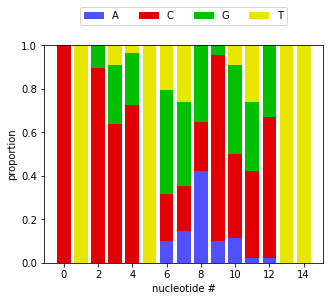

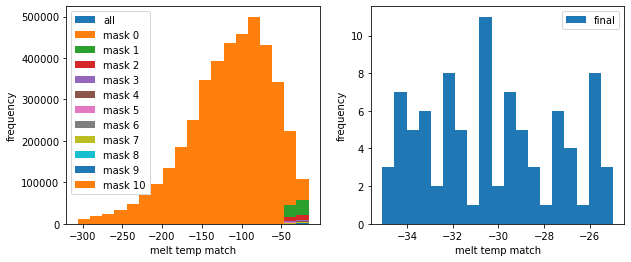

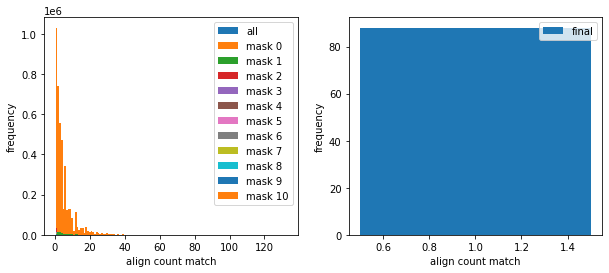

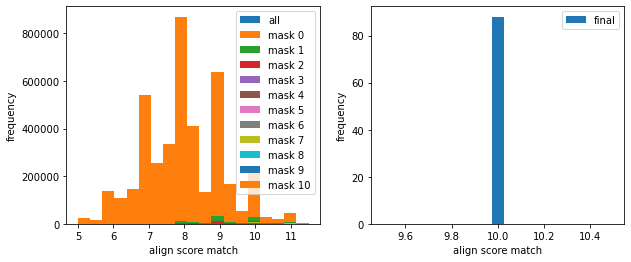

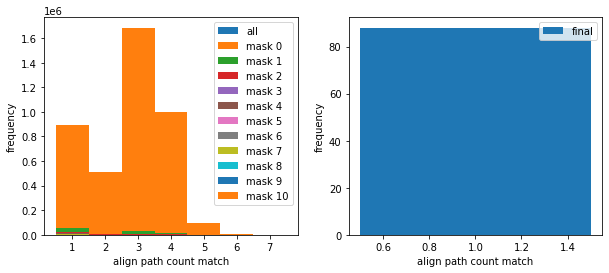

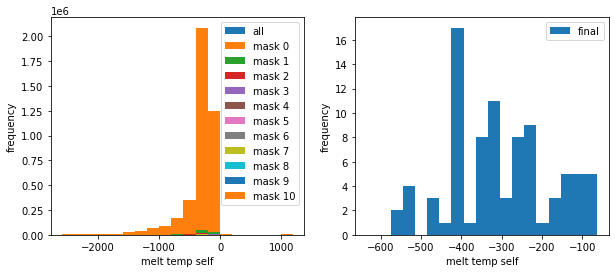

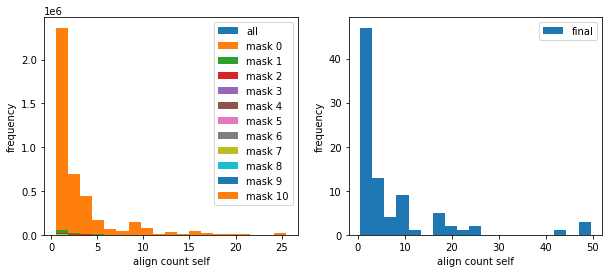

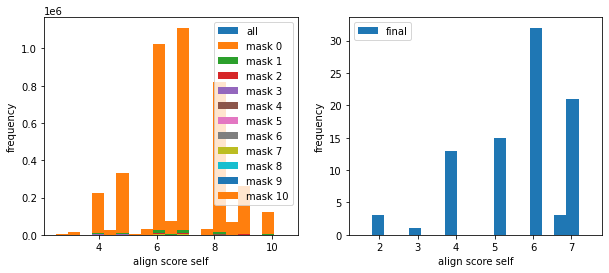

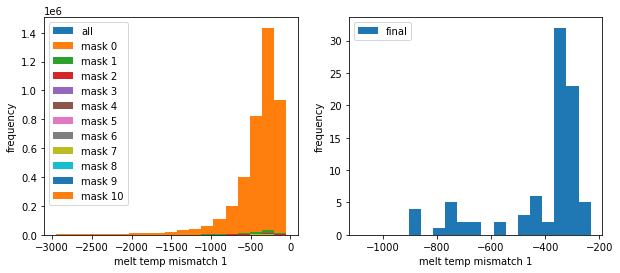

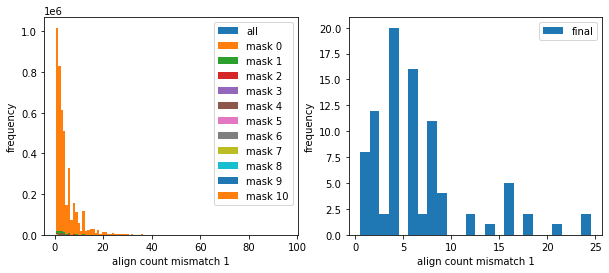

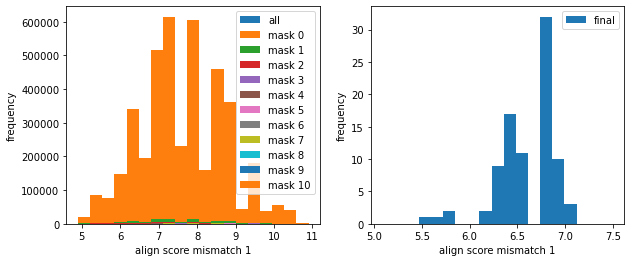

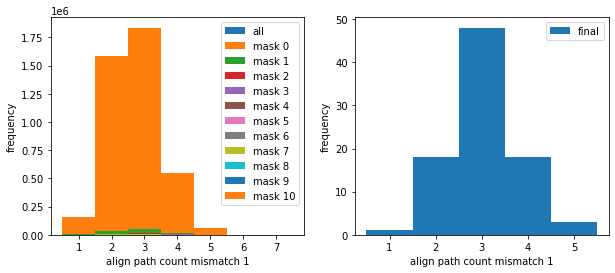

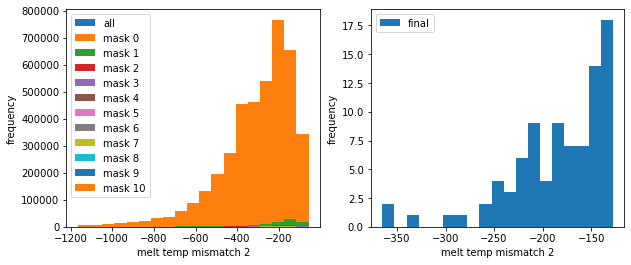

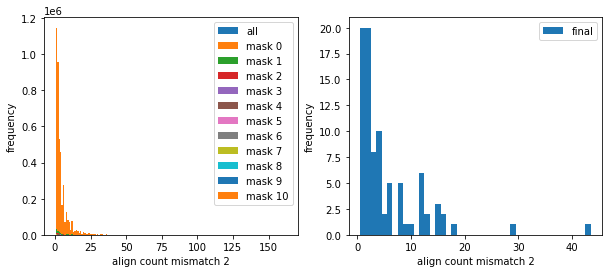

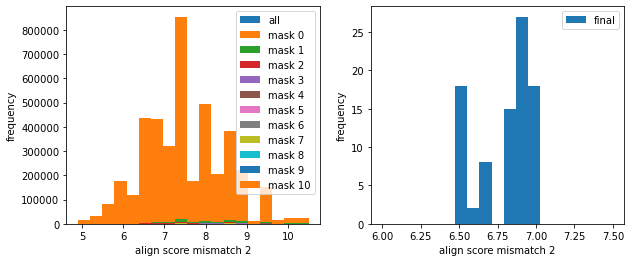

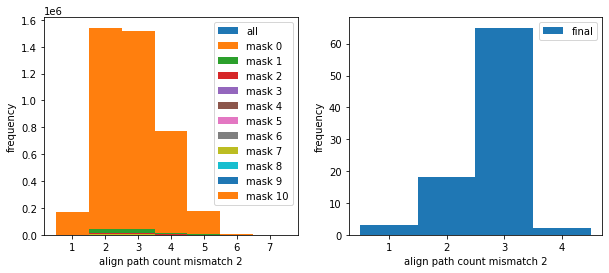

In [10]:
# screening for fast docking
masks = list()

# fix bases at specific positions
mask_seq = match_start(docking_results['seq'], imager_dict[imager_names[0]].reverse_complement(), 2, False)
mask_seq &= match_end(docking_results['seq'], imager_dict[imager_names[0]].reverse_complement(), 2, False)
# mask_seq &= (docking_results['seq'][:, 9] == "C")
masks.append(mask_seq)

# filter by melting temperature for a aligned fit against imager
mask_temp = np.ones_like(mask_seq) & (docking_results['melt temp match'] > -35) & (docking_results['melt temp match'] < -25)
masks.append(mask_temp)

# filter by how many possible alignments found (weak aligner)
mask_aligns = np.ones_like(mask_seq)
mask_aligns &= docking_results['align count match'] <= 1
masks.append(mask_aligns)

# filter by best alignments score (weak aligner)
mask_aligns = np.ones_like(mask_seq)
mask_aligns &= docking_results['align score match'] >= 10
masks.append(mask_aligns)

# filter by number of fragments in alignments (weak aligner)
mask_aligns = np.ones_like(mask_seq)
mask_aligns &= docking_results['align path count match'] <= 1
masks.append(mask_aligns)

# filter by best alignments score against its own sequence (weak aligner)
mask_aligns = np.ones_like(mask_seq)
mask_aligns &= docking_results['align score self'] <= 7
masks.append(mask_aligns)

# filter by difference in melting temperature between aligned fit against imger vs aligned fit against itself
mask_aligns = np.ones_like(mask_seq)
mask_aligns &= docking_results['melt temp self']+15 < docking_results['melt temp match']
masks.append(mask_aligns)

mask_aligns = np.ones_like(mask_seq)
mask_aligns &= docking_results['melt temp mismatch 1']+15 < docking_results['melt temp match']
masks.append(mask_aligns)

mask_aligns = np.ones_like(mask_seq)
mask_aligns &= docking_results['align score mismatch 1'] <= 7
masks.append(mask_aligns)

mask_aligns = np.ones_like(mask_seq)
mask_aligns &= docking_results['melt temp mismatch 2']+15 < docking_results['melt temp match']
masks.append(mask_aligns)

mask_aligns = np.ones_like(mask_seq)
mask_aligns &= docking_results['align score mismatch 2'] <= 7
masks.append(mask_aligns)

breakdown(docking_results, masks)

In [11]:
for i, seq in enumerate(docking_results[np.product(masks, axis=0).astype(bool)]['seq']):
    print("{}   {}".format(i, "".join(seq)))

0   CTCTCTTCGCCGCTT
1   CTCTCTTGGCGCCTT
2   CTCTCTCGACGGCTT
3   CTCTCTCGGCTGCTT
4   CTCTCTGAACGGCTT
5   CTCTCTGTGCGGCTT
6   CTCTCTGGACCGCTT
7   CTCTCTGGGCCTCTT
8   CTCCTTTTCCGGGTT
9   CTCCCTAAAAGTGTT
10   CTCCCTAAAGATGTT
11   CTCCCTAGAAATGTT
12   CTCCCTAGAAGTGTT
13   CTCCCTCTGCAGGTT
14   CTCCCTCTGCCGGTT
15   CTCCCTCCCCTGGTT
16   CTCCCTCCCCCGCTT
17   CTCCCTCCCCGCCTT
18   CTCCCTCCGCCTGTT
19   CTCCCTCGAAGTGTT
20   CTCCCTCGCCCGCTT
21   CTCCCTCGCCGCCTT
22   CTCCCTCGGCATGTT
23   CTCCCTCGGCCTGTT
24   CTCCCTGAAATGGTT
25   CTCCCTGAAAGTGTT
26   CTCCCTGAAGATGTT
27   CTCCCTGAAGTGGTT
28   CTCCCTGTCCGAATT
29   CTCCCTGTCCGAGTT
30   CTCCCTGTCCGGATT
31   CTCCCTGCAAGTGTT
32   CTCCCTGCCCACCTT
33   CTCCCTGCCCCCCTT
34   CTCCCTGCCCGTGTT
35   CTCCCTGCGCCTGTT
36   CTCCCTGGAAATGTT
37   CTCCCTGGAATGGTT
38   CTCCCTGGCCACCTT
39   CTCCCTGGCCCCCTT
40   CTCCCTGGGCCTGTT
41   CTCCGTTTCCCGGTT
42   CTCCGTTCCCGGCTT
43   CTCCGTTCGCCCCTT
44   CTCCGTCTGCGGCTT
45   CTCCGTCGGCCTCTT
46   CTCCGTGAACGTGTT
47   CTCCGTGAACGCCTT
48

In [12]:
def compare_list(ref_strand, sequences, masks):    
    compare(ref_strand, ref_strand.reverse_complement())
    sequences_masked = sequences[np.prod(np.asarray(masks), axis=0, dtype=bool)]
#     print (len(sequences_masked))
    for i, seq in enumerate(sequences_masked):
        print("{} / {}".format(i, len(sequences_masked)))
        seq = Seq.Seq("".join(seq))
        compare(ref_strand, seq, aligner)
        
compare_list(imager_dict["Imager B"], docking_results['seq'], masks)

AAGAAGTAAAGGGAG vs CTCCCTTTACTTCTT, 15.0 matches, 35.69 C melt. temp.
AAGAAGTAAAGGGAG
|||||||||||||||
AAGAAGTAAAGGGAG

0 / 88
AAGAAGTAAAGGGAG vs CTCTCTTCGCCGCTT, 10.0 matches, -31.90 C melt. temp.
AAGAAGTAAAGGGAG
|||..|..|||.|||
AAGCGGCGAAGAGAG

1 / 88
AAGAAGTAAAGGGAG vs CTCTCTTGGCGCCTT, 10.0 matches, -26.72 C melt. temp.
AAGAAGTAAAGGGAG
|||..|..|||.|||
AAGGCGCCAAGAGAG

2 / 88
AAGAAGTAAAGGGAG vs CTCTCTCGACGGCTT, 10.0 matches, -31.62 C melt. temp.
AAGAAGTAAAGGGAG
|||..||..||.|||
AAGCCGTCGAGAGAG

3 / 88
AAGAAGTAAAGGGAG vs CTCTCTCGGCTGCTT, 10.0 matches, -33.63 C melt. temp.
AAGAAGTAAAGGGAG
|||.||...||.|||
AAGCAGCCGAGAGAG

4 / 88
AAGAAGTAAAGGGAG vs CTCTCTGAACGGCTT, 10.0 matches, -28.97 C melt. temp.
AAGAAGTAAAGGGAG
|||..||..||.|||
AAGCCGTTCAGAGAG

5 / 88
AAGAAGTAAAGGGAG vs CTCTCTGTGCGGCTT, 10.0 matches, -30.43 C melt. temp.
AAGAAGTAAAGGGAG
|||..|.|.||.|||
AAGCCGCACAGAGAG

6 / 88
AAGAAGTAAAGGGAG vs CTCTCTGGACCGCTT, 10.0 matches, -31.90 C melt. temp.
AAGAAGTAAAGGGAG
|||..||..||.|||
AAGCGGTCC

C:\Users\Kenny\anaconda3\envs\pyme_py3\lib\site-packages\Bio\SeqUtils\MeltingTemp.py:841: BiopythonWarning: no themodynamic data for neighbors 'AA/GC' available. Calculation will be wrong
  BiopythonWarning,
C:\Users\Kenny\anaconda3\envs\pyme_py3\lib\site-packages\Bio\SeqUtils\MeltingTemp.py:841: BiopythonWarning: no themodynamic data for neighbors 'TA/GC' available. Calculation will be wrong
  BiopythonWarning,
C:\Users\Kenny\anaconda3\envs\pyme_py3\lib\site-packages\Bio\SeqUtils\MeltingTemp.py:841: BiopythonWarning: no themodynamic data for neighbors 'AA/CG' available. Calculation will be wrong
  BiopythonWarning,
C:\Users\Kenny\anaconda3\envs\pyme_py3\lib\site-packages\Bio\SeqUtils\MeltingTemp.py:841: BiopythonWarning: no themodynamic data for neighbors 'TA/GG' available. Calculation will be wrong
  BiopythonWarning,
C:\Users\Kenny\anaconda3\envs\pyme_py3\lib\site-packages\Bio\SeqUtils\MeltingTemp.py:841: BiopythonWarning: no themodynamic data for neighbors 'AA/GG' available. Calcul

In [15]:
def copy_to_clipboard(seq, data_dict, masks=None):
    if not masks is None:
        mask_all = np.prod(np.asarray(masks), axis=0, dtype=bool)
        data_dict_tmp = dict()
        for key, val in data_dict.items():
            data_dict_tmp[key] = val[mask_all]
        data_dict = data_dict_tmp
        seq = seq[mask_all]
    
    dframe_data = dict()
    for i in range(seq.shape[1]):
        dframe_data['base_{}'.format(i+1)] = seq[:,-1-i]
    for key, val in data_dict.items():
        dframe_data[key] = val
    dataFrame = pd.DataFrame.from_dict(dframe_data, )
    dataFrame.to_clipboard()
    display(dataFrame)

copy_to_clipboard(docking_results['seq'], {"melt temp match": docking_results['melt temp match']}, masks)

,base_1,base_2,base_3,base_4,base_5,base_6,base_7,base_8,base_9,base_10,base_11,base_12,base_13,base_14,base_15,melt temp match
0,T,T,C,G,C,C,G,C,T,T,C,T,C,T,C,-31.901140
1,T,T,C,C,G,C,G,G,T,T,C,T,C,T,C,-26.723079
2,T,T,C,G,G,C,A,G,C,T,C,T,C,T,C,-31.618966
3,T,T,C,G,T,C,G,G,C,T,C,T,C,T,C,-33.632767
4,T,T,C,G,G,C,A,A,G,T,C,T,C,T,C,-28.966861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,T,T,C,G,C,C,G,T,G,T,C,C,G,T,C,-29.456440
84,T,T,C,C,G,C,G,T,G,T,C,C,G,T,C,-32.683909
85,T,T,C,C,C,C,A,G,G,T,C,C,G,T,C,-34.280202
86,T,T,G,T,G,C,A,G,G,T,C,C,G,T,C,-30.133994
